# TCP Congestion Control NS2 Analysis

## Ali Ghanbari, Ahoora Shiri

This notebook provides an analysis of various TCP congestion control algorithms, specifically focusing on **Newreno**, **Tahoe**, and **Vegas**, implemented in NS2. These algorithms are crucial in managing network traffic and ensuring optimal performance. They help to prevent network congestion by adjusting the amount of data sent over the network based on the current network conditions.

The **Newreno** algorithm improves upon the original Reno algorithm by introducing fast retransmit and fast recovery mechanisms. Fast retransmit allows the sender to retransmit a lost packet immediately upon receiving three duplicate acknowledgments, reducing the time a sender waits before retransmitting a lost segment. Fast recovery is another feature of Newreno, which helps to recover from packet losses without having to go through the slow start phase.

The **Tahoe** algorithm, on the other hand, operates under the principle of 'wait and see'. It uses a coarse-grained timeout approach, where it waits until a timeout event occurs before taking action to reduce congestion. This makes Tahoe slower in reacting to congestion compared to Newreno but less likely to unnecessarily reduce the sending rate.

Lastly, the **Vegas** algorithm is designed to provide a balance between Tahoe and Newreno. It uses a combination of the fast retransmit and fast recovery mechanisms of Newreno, along with the coarse-grained timeout approach of Tahoe. Vegas also includes a mechanism to estimate the network bandwidth and adjust the sending rate accordingly, providing a more efficient use of network resources.

## Table of Contents

- [Topology Implementation Assumptions](#0)
- [Packages](#1)
- [Hyperparameters](#2)
- [Tools Class](#3)
- [Simulator Class](#4)
- [Train Simulators](#5)
- [Congestion Window (CWND)](#6)
    - [Newreno Algorithm](#6-0)
    - [Tahoe Algorithm](#6-1)
    - [Vegas Algorithm](#6-2)
- [Goodput Metric](#7)
    - [Newreno Algorithm](#7-0)
    - [Tahoe Algorithm](#7-1)
    - [Vegas Algorithm](#7-2)
- [Drop Rate Metric](#8)
    - [Method 1: Time Interval Drops](#8-0)
        - [Newreno Algorithm](#8-0-0)
        - [Tahoe Algorithm](#8-0-1)
        - [Vegas Algorithm](#8-0-2)
    - [Method 2: Acknowledgment-based Drops](#8-1)
        - [Newreno Algorithm](#8-1-0)
        - [Tahoe Algorithm](#8-1-1)
        - [Vegas Algorithm](#8-1-2)
- [Round-Trip Time (RTT) Metric](#9)
    - [Newreno Algorithm](#9-0)
    - [Tahoe Algorithm](#9-1)
    - [Vegas Algorithm](#9-2)

<a name='0'></a>
## Topology Implementation Assumptions

- We used ftp to transfer packets and assigned them to nodes 1 and 2 as agents.
- To implement router queue limits we assigned queue limit to each of routers output links.

<a name='1'></a>
## Packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

<a name='2'></a>
## Hyperparameters

In [2]:
SIMULATION_COUNT        = 10
SIMULATION_TIME         = 1000
TCL_FILENAME            = "../network_simulation.tcl"
TRACE_FILENAME          = "simulation.tr"
OUTPUT_ENDING           = ".csv"
IMAGE_ENDING            = ".png"
CWND_DATA_NAME          = "cwnd"
GOODPUT_DATA_NAME       = "goodput"
DROP_METHOD_1_DATA_NAME = "drop_method_1"
DROP_METHOD_2_DATA_NAME = "drop_method_2"
RTT_DATA_NAME           = "rtt"
PATH_SIMULATION_OUTPUTS = "network simulation outputs"
PATH_PLOTS              = "plots"
CWND                    = "CWND"
GOODPUT                 = "Goodput"
DROPRATE                = "DropRate"
METHOD1                 = "Method1"
METHOD2                 = "Method2"
RTT                     = "RTT"
NEWRENO                 = "Newreno"
TAHOE                   = "Tahoe"
VEGAS                   = "Vegas"
DELIMITER               = "-"

In [3]:
plt.rcParams["figure.figsize"] = (14, 5) 

<a name='3'></a>
## Tools Class

In [4]:
class Tools:
    def plot_data(self, data_1, data_2, save_path):
        plt.plot(data_1, "b", label="Top flow")
        plt.plot(data_2, "r", label="Bottom flow")
        plt.xlabel("time")
        plt.ylabel(data_1.name)
        plt.legend()
        if save_path:
            if not os.path.exists(PATH_PLOTS):
                os.makedirs(PATH_PLOTS)
            plt.savefig(save_path)

        plt.show()


    def read_file(self, filename):
        with open(filename) as input_file:
            file_content = input_file.readlines()
            file_content = [x.split() for x in file_content]
            return file_content

<a name='4'></a>
## Simulator Class

In [5]:
class Simulator:
    def __init__(self, congestion_algorithm):
        self.congestion_algorithm = congestion_algorithm
        self.tools = Tools()
        self.data = {}

In [6]:
def train(self):
    if not os.path.exists(PATH_SIMULATION_OUTPUTS):
        os.makedirs(PATH_SIMULATION_OUTPUTS)

    for i in range(0, SIMULATION_COUNT):
        os.chdir(PATH_SIMULATION_OUTPUTS)

        ns_command = "ns " + TCL_FILENAME + " " + self.congestion_algorithm
        os.system(ns_command)

        self.update_data(i, CWND_DATA_NAME)
        self.update_data(i, GOODPUT_DATA_NAME)
        self.update_data(i, DROP_METHOD_1_DATA_NAME)
        self.update_data(i, DROP_METHOD_2_DATA_NAME)
        self.update_data(i, RTT_DATA_NAME)

        os.chdir('..')


Simulator.train = train

In [7]:
def get_dict_key(self, data_name, index):
    return data_name + "_" + str(index)


Simulator.get_dict_key = get_dict_key

In [8]:
def read_updated_data(self, data_name):
    if data_name == DROP_METHOD_1_DATA_NAME:
        new_data_1 = self.get_drop_rates_method_1("1")
        new_data_2 = self.get_drop_rates_method_1("2")
    elif data_name == DROP_METHOD_2_DATA_NAME:
        new_data_1 = self.get_drop_rates_method_2("1")
        new_data_2 = self.get_drop_rates_method_2("2")
    else:
        new_data_1 = pd.read_csv(data_name + "1" + OUTPUT_ENDING)
        new_data_2 = pd.read_csv(data_name + "2" + OUTPUT_ENDING)

    return new_data_1, new_data_2


Simulator.read_updated_data = read_updated_data

In [9]:
def update_data(self, simulation_index, data_name):
    new_data_1, new_data_2 = self.read_updated_data(data_name)

    data_dict_key_1 = self.get_dict_key(data_name, 1)
    data_dict_key_2 = self.get_dict_key(data_name, 2)

    if simulation_index == 0:
        self.data[data_dict_key_1] = new_data_1[data_name]
        self.data[data_dict_key_2] = new_data_2[data_name]
    else:
        self.data[data_dict_key_1] += new_data_1[data_name]
        self.data[data_dict_key_2] += new_data_2[data_name]

    if simulation_index == SIMULATION_COUNT - 1:
        self.data[data_dict_key_1] /= SIMULATION_COUNT
        self.data[data_dict_key_2] /= SIMULATION_COUNT


Simulator.update_data = update_data

In [10]:
def plot_data(self, data_name, save_path=None):
    data_1 = self.data[self.get_dict_key(data_name, 1)]
    data_2 = self.data[self.get_dict_key(data_name, 2)]
    self.tools.plot_data(data_1, data_2, save_path)


Simulator.plot_data = plot_data

In [11]:
def get_drop_rates_method_1(self, flow_id):
    drop_rates = [0] * SIMULATION_TIME
    
    trace_file = self.tools.read_file(TRACE_FILENAME)
    
    for trace_line in trace_file:
        if trace_line[0] == 'd' and trace_line[7] == flow_id:
            time_index = int(float(trace_line[1]))
            drop_rates[time_index] += 1
    
    return pd.DataFrame(drop_rates, columns=[DROP_METHOD_1_DATA_NAME])


Simulator.get_drop_rates_method_1 = get_drop_rates_method_1

In [12]:
from __future__ import division


def get_drop_rates_method_2(self, flow_id):
    drop_counts, number_of_acks = self.get_drop_rate_info(flow_id)
    
    number_of_acks_per_second = [1] * SIMULATION_TIME
    for i in range(1, SIMULATION_TIME):
        number_of_acks_per_second[i] = max(1, number_of_acks[i] - number_of_acks[i - 1])
    
    drop_rates = [x / y for x, y in zip(drop_counts, number_of_acks_per_second)]
    
    return pd.DataFrame(drop_rates, columns=[DROP_METHOD_2_DATA_NAME])


Simulator.get_drop_rates_method_2 = get_drop_rates_method_2

In [13]:
def get_drop_rate_info(self, flow_id):
    drop_counts = [0] * SIMULATION_TIME
    number_of_acks = [0] * SIMULATION_TIME

    trace_file = self.tools.read_file(TRACE_FILENAME)

    for trace_line in trace_file:
        if trace_line[7] == flow_id:
            time_index = int(float(trace_line[1]))
            if trace_line[0] == 'd':
                drop_counts[time_index] += 1
            elif trace_line[0] == 'r' and trace_line[4] == "ack":
                number_of_acks[time_index] = max(number_of_acks[time_index], int(trace_line[10]))

    return drop_counts, number_of_acks


Simulator.get_drop_rate_info = get_drop_rate_info

<a name='5'></a>
## Train Simulators

In [14]:
new_reno_simulator = Simulator(NEWRENO)
new_reno_simulator.train()

In [15]:
tahoe_simulator = Simulator(TAHOE)
tahoe_simulator.train()

In [16]:
vegas_simulator = Simulator(VEGAS)
vegas_simulator.train()

<a name='6'></a>
## Congestion Window (CWND)

***Assumption***: Congestion window size is sampled in each second.

<a name='6-0'></a>
### Newreno Algorithm

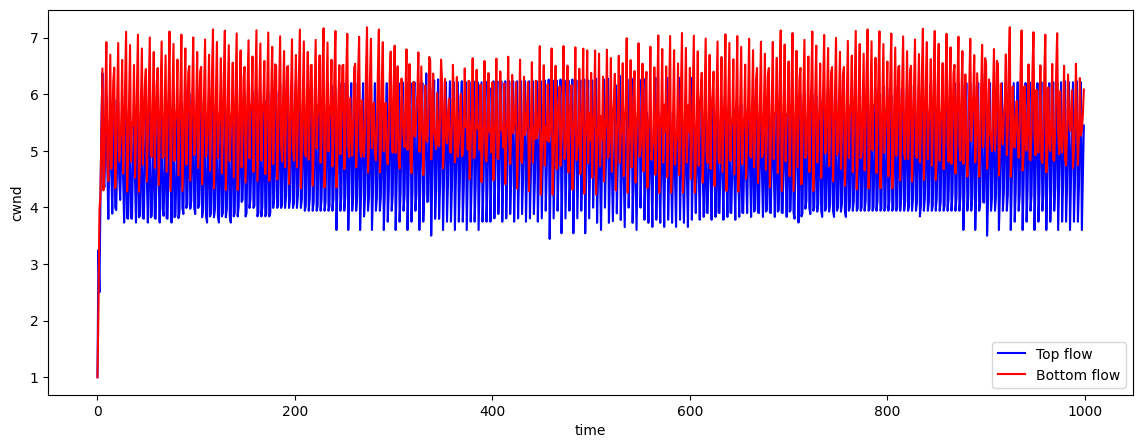

In [17]:
save_path = os.path.join(PATH_PLOTS, CWND + DELIMITER + NEWRENO + IMAGE_ENDING)
new_reno_simulator.plot_data(CWND_DATA_NAME, save_path)

<a name='6-1'></a>
### Tahoe Algorithm

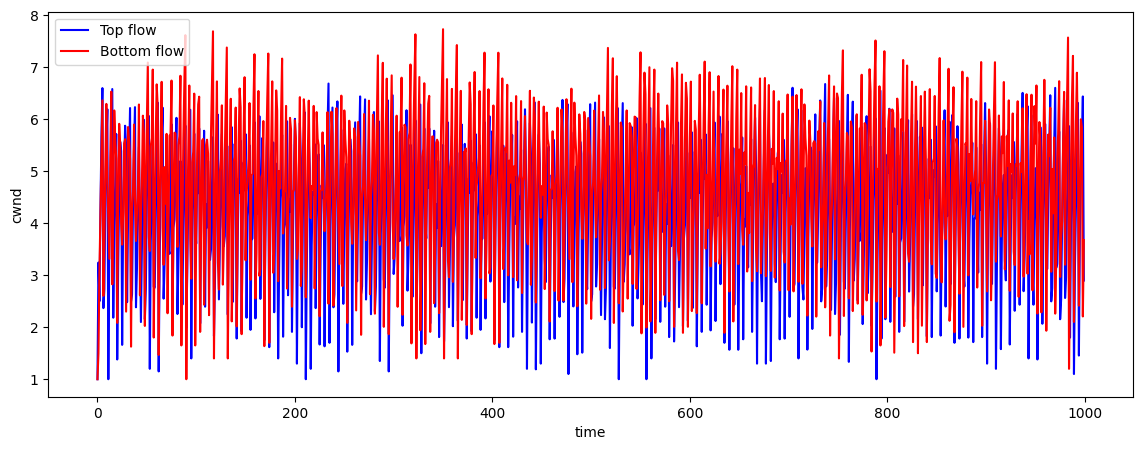

In [18]:
save_path = os.path.join(PATH_PLOTS, CWND + DELIMITER + TAHOE + IMAGE_ENDING)
tahoe_simulator.plot_data(CWND_DATA_NAME, save_path)

<a name='6-2'></a>
### Vegas Algorithm

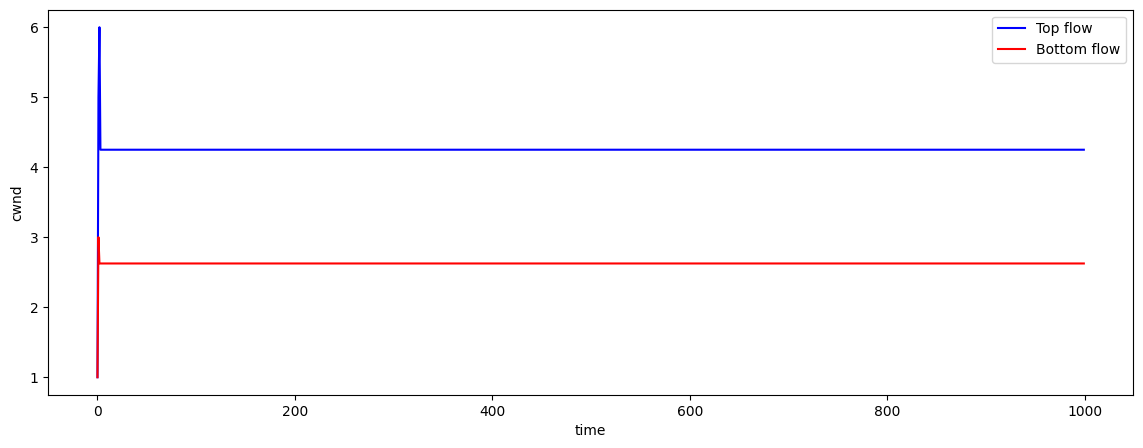

In [19]:
save_path = os.path.join(PATH_PLOTS, CWND + DELIMITER + VEGAS + IMAGE_ENDING)
vegas_simulator.plot_data(CWND_DATA_NAME, save_path)

<a name='7'></a>
## Goodput Metric

***Assumption***: Goodput rate is measured as number of acknowledged bits received in each second time interval.

<a name='7-0'></a>
### Newreno Algorithm

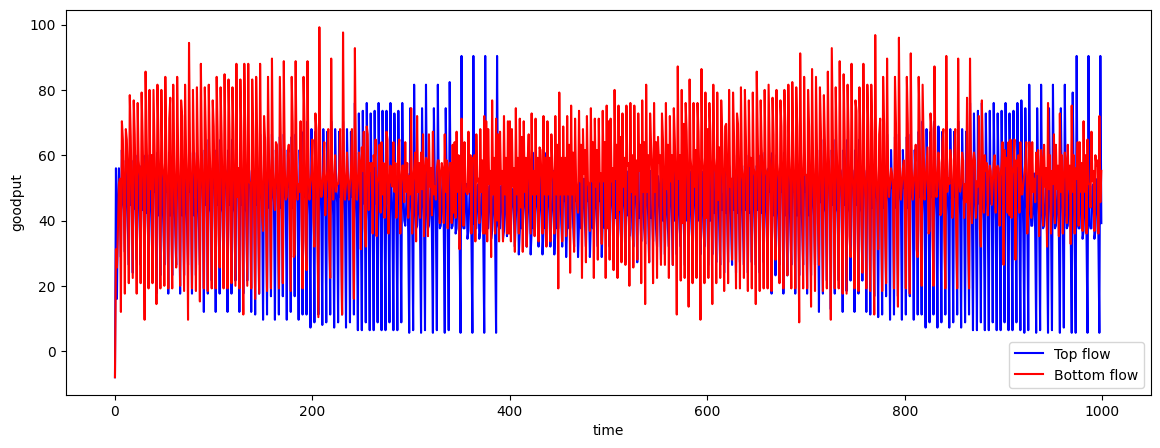

In [20]:
save_path = os.path.join(PATH_PLOTS, GOODPUT + DELIMITER + NEWRENO + IMAGE_ENDING)
new_reno_simulator.plot_data(GOODPUT_DATA_NAME, save_path)

<a name='7-1'></a>
### Tahoe Algorithm

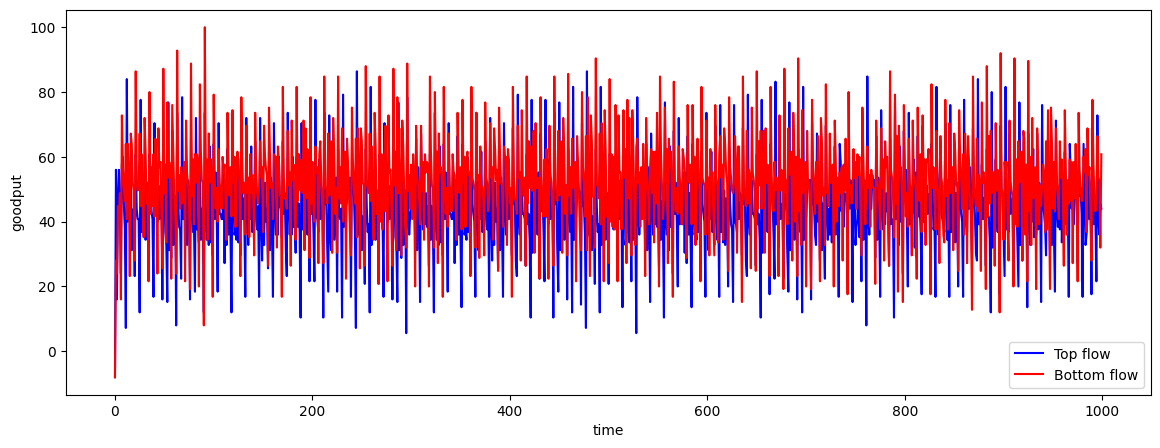

In [21]:
save_path = os.path.join(PATH_PLOTS, GOODPUT + DELIMITER + TAHOE + IMAGE_ENDING)
tahoe_simulator.plot_data(GOODPUT_DATA_NAME, save_path)

<a name='7-2'></a>
### Vegas Algorithm

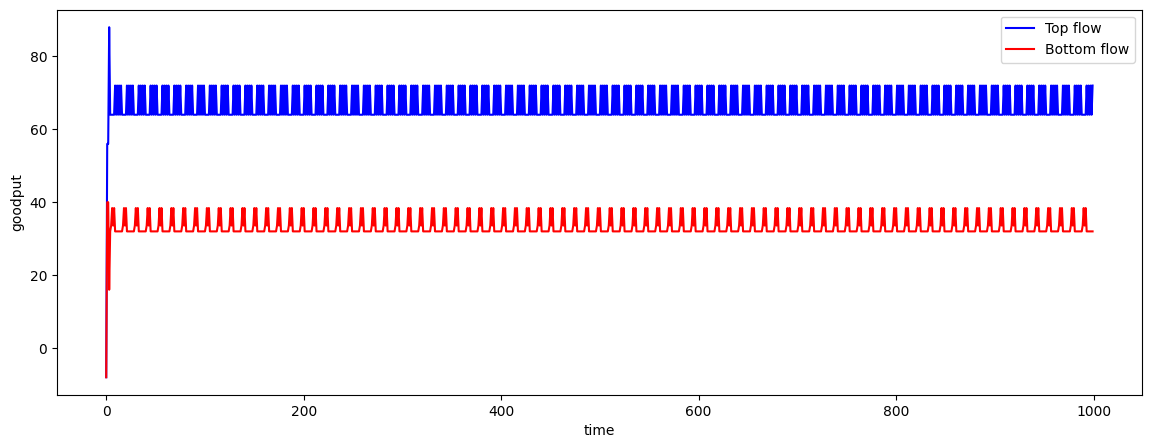

In [22]:
save_path = os.path.join(PATH_PLOTS, GOODPUT + DELIMITER + VEGAS + IMAGE_ENDING)
vegas_simulator.plot_data(GOODPUT_DATA_NAME, save_path)

<a name='8'></a>
## Drop Rate Metric

***Assumptions***: Due to ambiguity of drop rate definition two methods to measure drop rate is implemented:

<a name='8-0'></a>
### Method 1: Time Interval Drops

In this method drop rate is measured as number of drops in each second time interval.

<a name='8-0-0'></a>
#### Newreno Algorithm

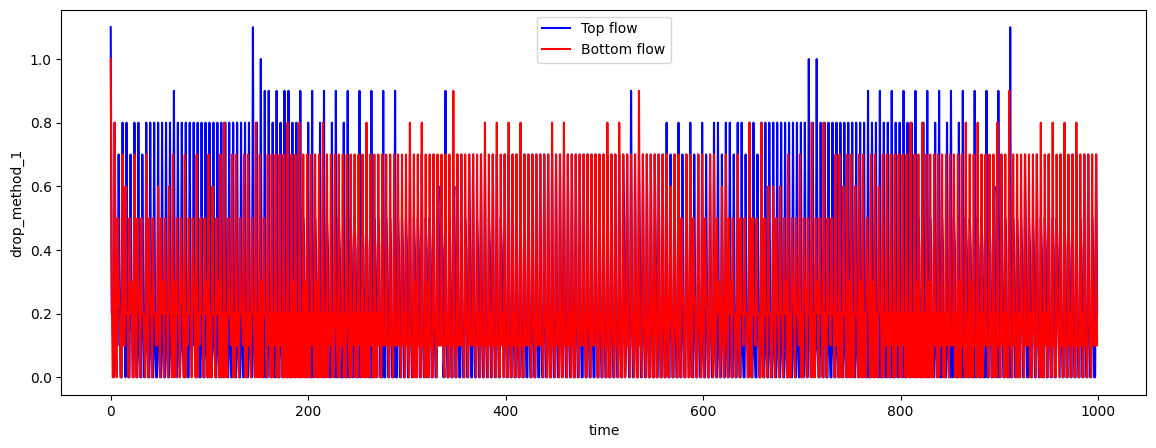

In [23]:
save_path = os.path.join(PATH_PLOTS, DROPRATE + DELIMITER + METHOD1 + DELIMITER + NEWRENO + IMAGE_ENDING)
new_reno_simulator.plot_data(DROP_METHOD_1_DATA_NAME, save_path)

<a name='8-0-1'></a>
#### Tahoe Algorithm

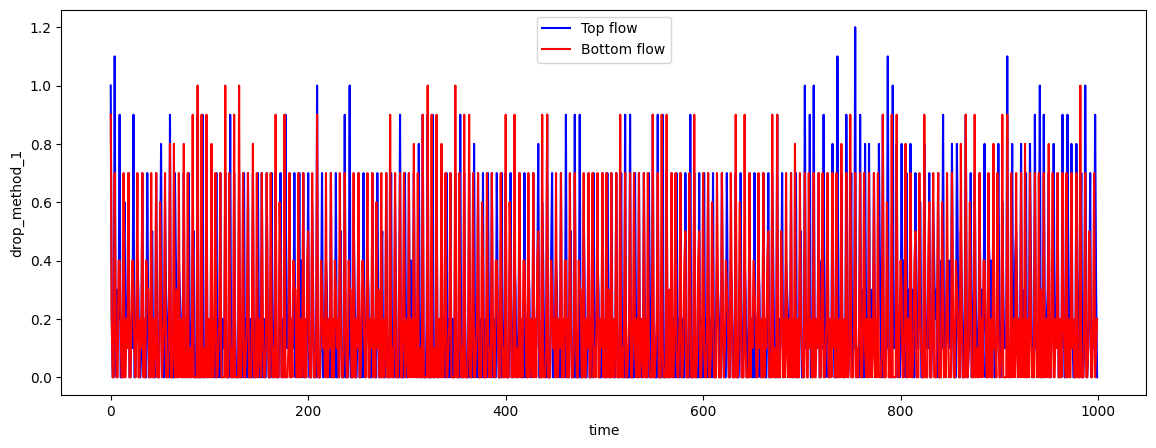

In [24]:
save_path = os.path.join(PATH_PLOTS, DROPRATE + DELIMITER + METHOD1 + DELIMITER + TAHOE + IMAGE_ENDING)
tahoe_simulator.plot_data(DROP_METHOD_1_DATA_NAME, save_path)

<a name='8-0-2'></a>
#### Vegas Algorithm

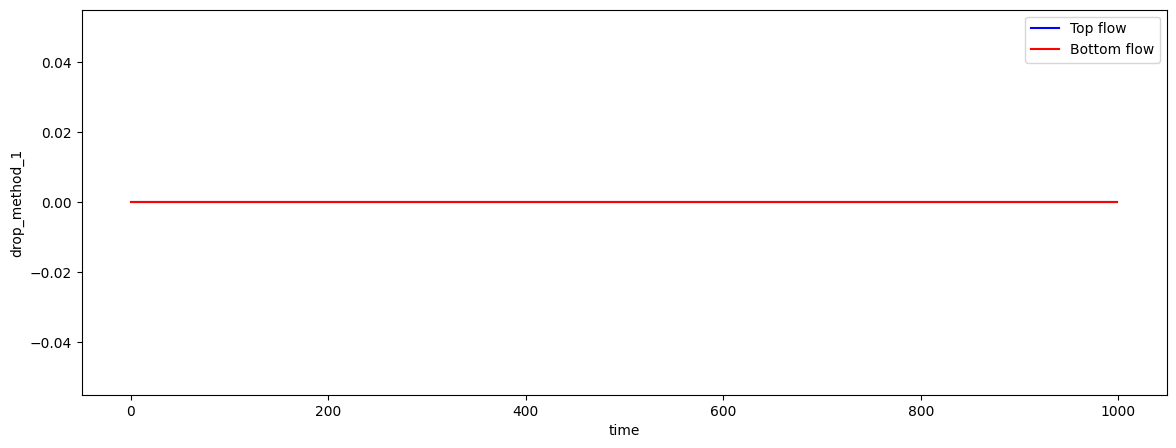

In [25]:
save_path = os.path.join(PATH_PLOTS, DROPRATE + DELIMITER + METHOD1 + DELIMITER + VEGAS + IMAGE_ENDING)
vegas_simulator.plot_data(DROP_METHOD_1_DATA_NAME, save_path)

<a name='8-1'></a>
### Method 2: Acknowledgment-based Drops

This method is based on description on [this website](http://intronetworks.cs.luc.edu/current/html/ns2.html#loss-rate-versus-cwnd-part-1). In this method, drop rate is calculated as number of packets dropped divided by number of packets acknowledged in each second time interval.

<a name='8-1-0'></a>
#### Newreno Algorithm

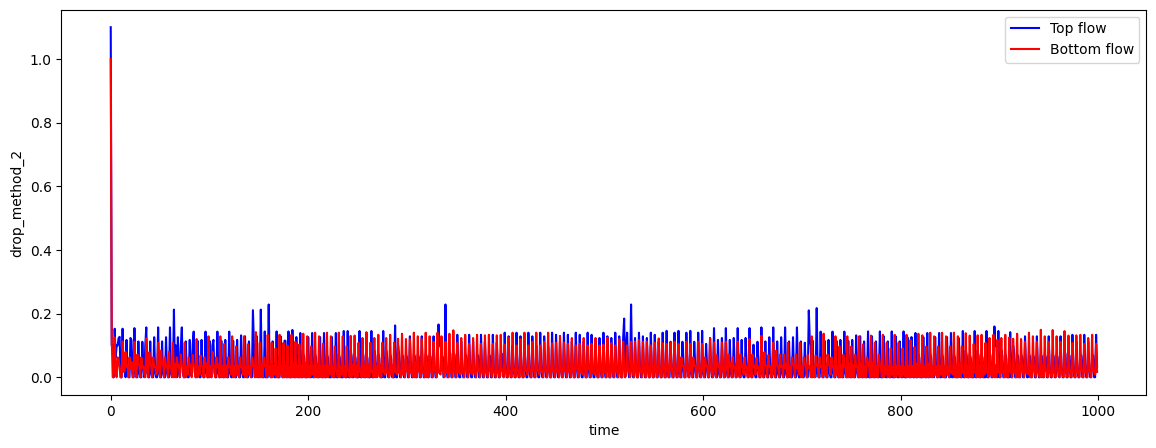

In [26]:
save_path = os.path.join(PATH_PLOTS, DROPRATE + DELIMITER + METHOD2 + DELIMITER + NEWRENO + IMAGE_ENDING)
new_reno_simulator.plot_data(DROP_METHOD_2_DATA_NAME, save_path)

<a name='8-1-1'></a>
#### Tahoe Algorithm

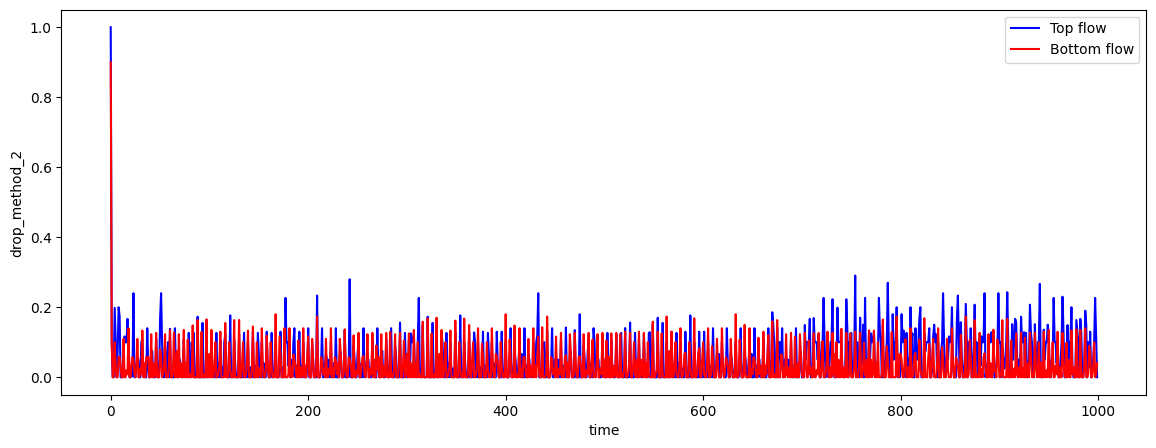

In [27]:
save_path = os.path.join(PATH_PLOTS, DROPRATE + DELIMITER + METHOD2 + DELIMITER + TAHOE + IMAGE_ENDING)
tahoe_simulator.plot_data(DROP_METHOD_2_DATA_NAME, save_path)

<a name='8-1-2'></a>
#### Vegas Algorithm

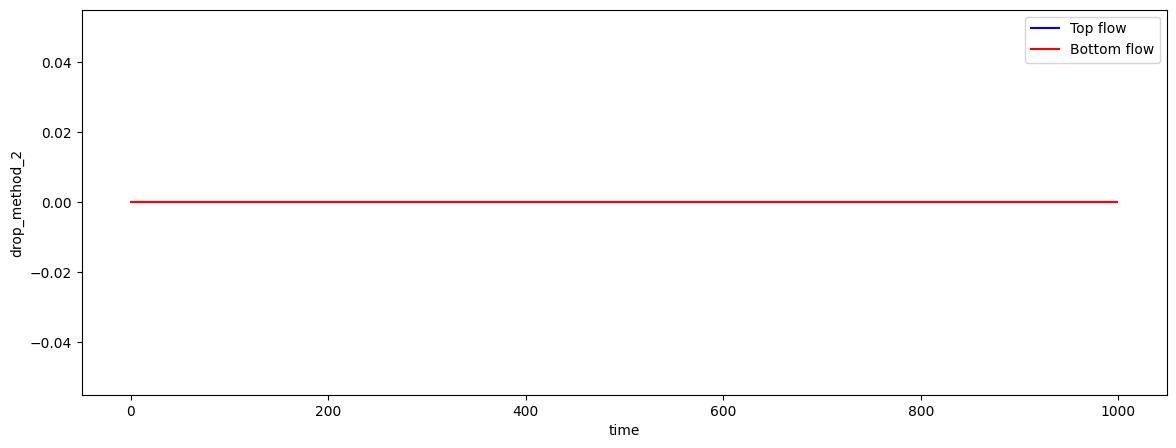

In [28]:
save_path = os.path.join(PATH_PLOTS, DROPRATE + DELIMITER + METHOD2 + DELIMITER + VEGAS + IMAGE_ENDING)
vegas_simulator.plot_data(DROP_METHOD_2_DATA_NAME, save_path)

<a name='9'></a>
## Round-Trip Time (RTT) Metric

***Assumption***: RTT is measured as current RTT in flow using flow's rtt field in ns2 in each second.

<a name='9-0'></a>
### Newreno Algorithm

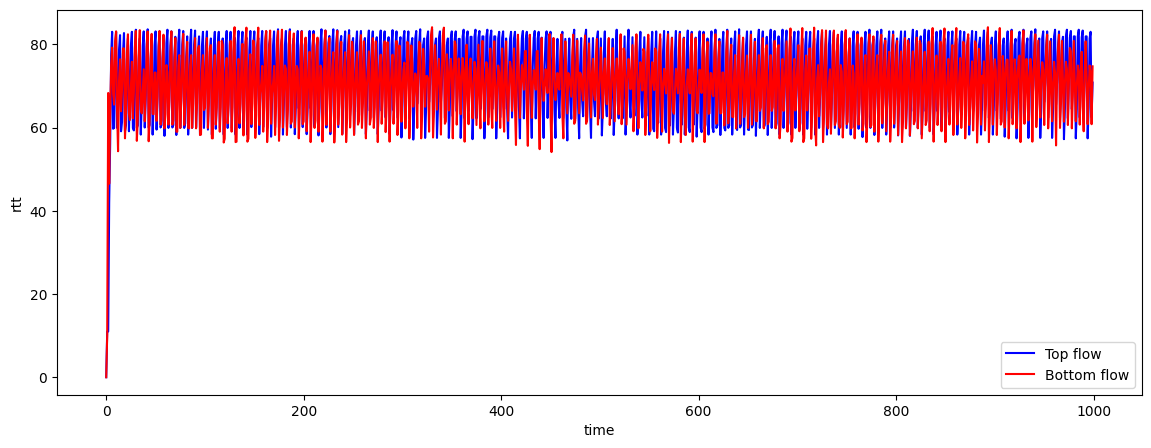

In [29]:
save_path = os.path.join(PATH_PLOTS, RTT + DELIMITER + NEWRENO + IMAGE_ENDING)
new_reno_simulator.plot_data(RTT_DATA_NAME, save_path)

<a name='9-1'></a>
### Tahoe Algorithm

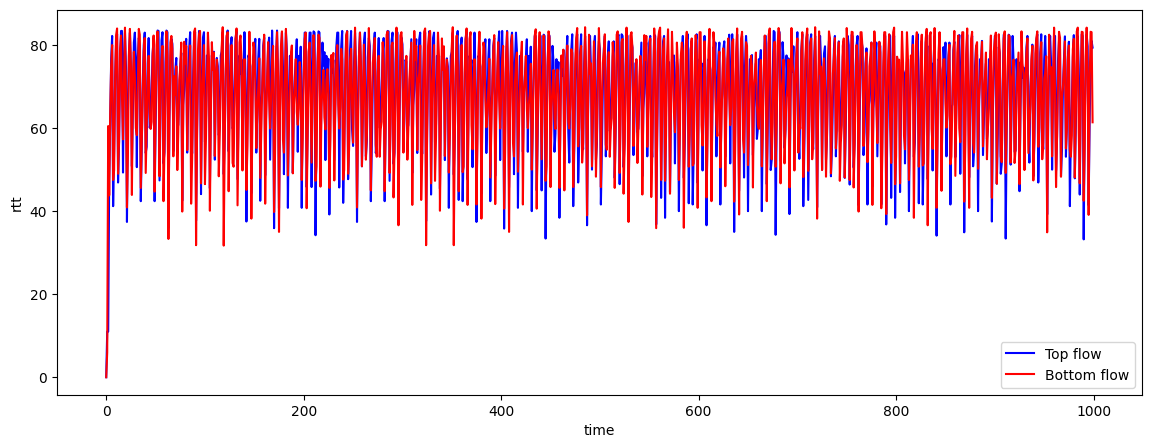

In [30]:
save_path = os.path.join(PATH_PLOTS, RTT + DELIMITER + TAHOE + IMAGE_ENDING)
tahoe_simulator.plot_data(RTT_DATA_NAME, save_path)

<a name='9-2'></a>
### Vegas Algorithm

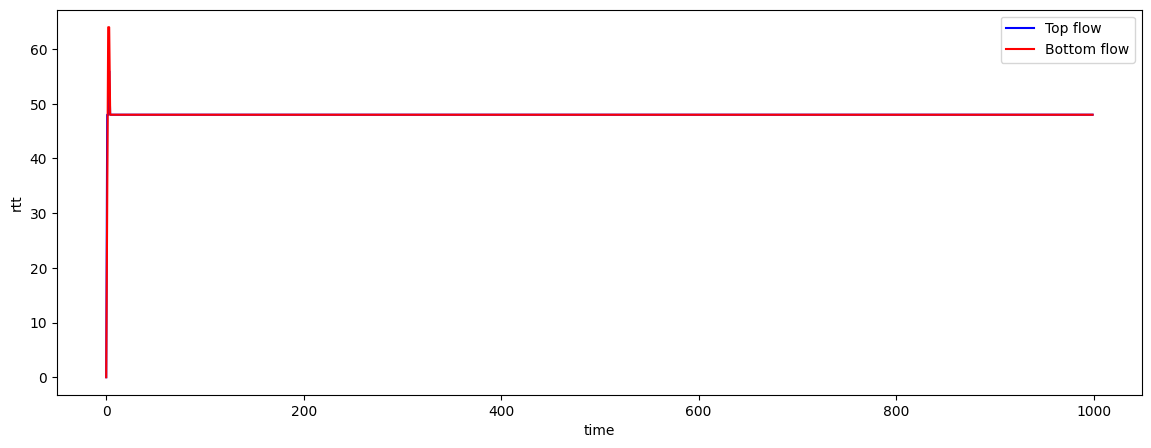

In [31]:
save_path = os.path.join(PATH_PLOTS, RTT + DELIMITER + VEGAS + IMAGE_ENDING)
vegas_simulator.plot_data(RTT_DATA_NAME, save_path)